<a href="https://colab.research.google.com/github/seismosmsr/hawaii_soils/blob/main/Hawaii_Soils_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages('sf')
install.packages('raster')
install.packages('exactextractr')
install.packages("googledrive")
install.packages("googletoken")
install.packages("DBI")
install.packages("RSQLite")
install.packages("RPostgreSQL")
install.packages("terra")
install.packages('randomForest')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘googletoken’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the

In [78]:
library(ggplot2)
library(sf)
library(magrittr)
library(data.table)
library(raster)
library(exactextractr)
library(googledrive)
library(DBI)
library(terra)
library(randomForest)
library(parallel)

In [3]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=12c4f861d89206df11cdec76e2f16b03&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbjRvdEMyc1ZNS012STh5X2hIeFZMSkx5cVoxQkJPREdXeXhtQS1BVUJCUjMtNnVXdUZwR0plVG5zRDhwenBtUSIsInN0YXRlIjoiMTJjNGY4NjFkODkyMDZkZjExY2RlYzc2ZTJmMTZiMDMifQ==


In [18]:
# https://drive.google.com/file/d/1ryTzWz0t9mgI5ynPvMzM21D135dLJvWv/view?usp=drive_link
# Updated: https://drive.google.com/file/d/17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C/view?usp=sharing
drive_download(as_id('17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C'), path = paste0('/content/fia.csv'), overwrite = TRUE)
fia_dt <-  st_read('/content/fia.csv') %>% st_as_sf(coords = c("LON","LAT"), crs = 4326) %>% data.table

File downloaded:

• 2023_11_01FIA_soil_subset.csv <id: 17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C>

Saved locally as:

• /content/fia.csv



Reading layer `fia' from data source `/content/fia.csv' using driver `CSV'


Warning message:
“no simple feature geometries present: returning a data.frame or tbl_df”


In [165]:
# https://drive.google.com/file/d/1G-qBpO_nzLIHWZQGNyrSutmBonjsrvEJ/view?usp=drive_link
drive_download(as_id('1G-qBpO_nzLIHWZQGNyrSutmBonjsrvEJ'), path = "/content/250_summary_grid_dt.gpkg", overwrite = TRUE)
grid_dt <- st_read("/content/250_summary_grid_dt.gpkg") %>% st_transform(4326) %>% data.table()

File downloaded:

• 250_summary_grid_full_dt.gpkg <id: 1G-qBpO_nzLIHWZQGNyrSutmBonjsrvEJ>

Saved locally as:

• /content/250_summary_grid_dt.gpkg



Reading layer `250_summary_grid_full_dt' from data source 
  `/content/250_summary_grid_dt.gpkg' using driver `GPKG'
Simple feature collection with 227561 features and 35 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 57161.36 ymin: 16952.32 xmax: 572661.4 ymax: 381202.3
Projected CRS: NAD_1983_HARN_StatePlane_Hawaii_1_FIPS_5101


In [166]:
grid_dt <- grid_dt[trees >0.5 & !is.na(agbd_m)]

In [266]:
grid_int_dt  <- fia_dt$geom %>% st_transform(4135) %>% st_buffer(800) %>% st_transform(4326) %>% st_intersects(grid_dt$geom)

In [267]:
rm_vec <- grid_int_dt %>% lapply(length) %>% unlist > 0
grid_int_dt <- grid_int_dt[rm_vec]
fia_dt <- fia_dt[rm_vec,]

In [268]:
grid_dt <- grid_dt[!is.na(srad),]

In [269]:
grid_dt$agbd_n <- grid_dt$agbd_n %>% as.numeric

In [270]:
fia_dt$Stock_SOC_Mg_Ha <- fia_dt$Stock_SOC_Mg_Ha %>% as.numeric

In [265]:
rf_dt <- data.table(fia_dt[,c('PLOT','Stock_SOC_Mg_Ha','geometry')], grid_dt[grid_int_dt %>% lapply(function(x){x %>% sample(1)}) %>% unlist,])

x_var <- (rf_dt %>% names)[-c(1,2,3,4,5,6,7,8,ncol(rf_dt))]

rf_form <- as.formula(paste0('Stock_SOC_Mg_Ha~',paste(x_var,collapse = '+')))

rf_dt <-  rf_dt[complete.cases(rf_dt[,-c(3,ncol(rf_dt)),with=F]),]

rf_terra <- randomForest(rf_form,rf_dt,verbose=T)

rf_imp_dt <- rf_terra$importance %>% t %>% data.table

names(rf_imp_dt) <-paste0('var_imp_',names(rf_imp_dt))

out_dt <- data.table(rf_dt,data.table(predicted = rf_terra$predicted),rf_imp_dt[rep(1,nrow(rf_dt)),])

Stock_SOC_Mg_Ha ~ water + trees + grass + flooded_vegetation + 
    crops + shrub_and_scrub + built + bare + snow_and_ice + max + 
    elevation + landform + SRTM_mTPI + aet + def + pdsi + pet + 
    pr + ro + soil + srad + swe + tmmn + tmmx + vap + vpd + vs + 
    agbd_m + agbd_sd + agbd_n


[1] -0.1335536

In [ ]:
cl <-makeCluster(8)
sim_dt <-
1:1000 %>% parLapply(cl,.,function(m,fia_dt,grid_dt,grid_int_dt){
  library(sf)
  library(magrittr)
  library(data.table)
  library(raster)
  library(exactextractr)
  library(terra)
  library(randomForest)


  rf_dt <- data.table(fia_dt[,c('PLOT','Stock_SOC_Mg_Ha','geometry')], grid_dt[grid_int_dt %>% lapply(function(x){x %>% sample(1)}) %>% unlist,])

  x_var <- (rf_dt %>% names)[-c(1,2,3,4,5,6,7,8,ncol(rf_dt))]

  rf_form <- as.formula(paste0('Stock_SOC_Mg_Ha~',paste(x_var,collapse = '+')))

  rf_dt <-  rf_dt[complete.cases(rf_dt[,-c(3,ncol(rf_dt)),with=F]),]

  rf_terra <- randomForest(rf_form,rf_dt,verbose=T)

  rf_imp_dt <- rf_terra$importance %>% t %>% data.table

  names(rf_imp_dt) <-paste0('var_imp_',names(rf_imp_dt))

  out_dt <- data.table(rf_dt,data.table(predicted = rf_terra$predicted),rf_imp_dt[rep(1,nrow(rf_dt)),])
  out_dt$r2 <- rf_terra$rsq[500]
  return(out_dt)
  },fia_dt,grid_dt,grid_int_dt) %>%
  rbindlist
stopCluster(cl)

In [ ]:
# Write to GeoPackage
sim_dt %>% st_write("/content/sim_results_Full_Run3.gpkg", append=FALSE)

In [ ]:
# https://drive.google.com/drive/folders/1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM?usp=drive_link
drive_upload("/content/sim_results_Full_Run1.gpkg", path = as_id("1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM"))

In [ ]:
# sim_dt

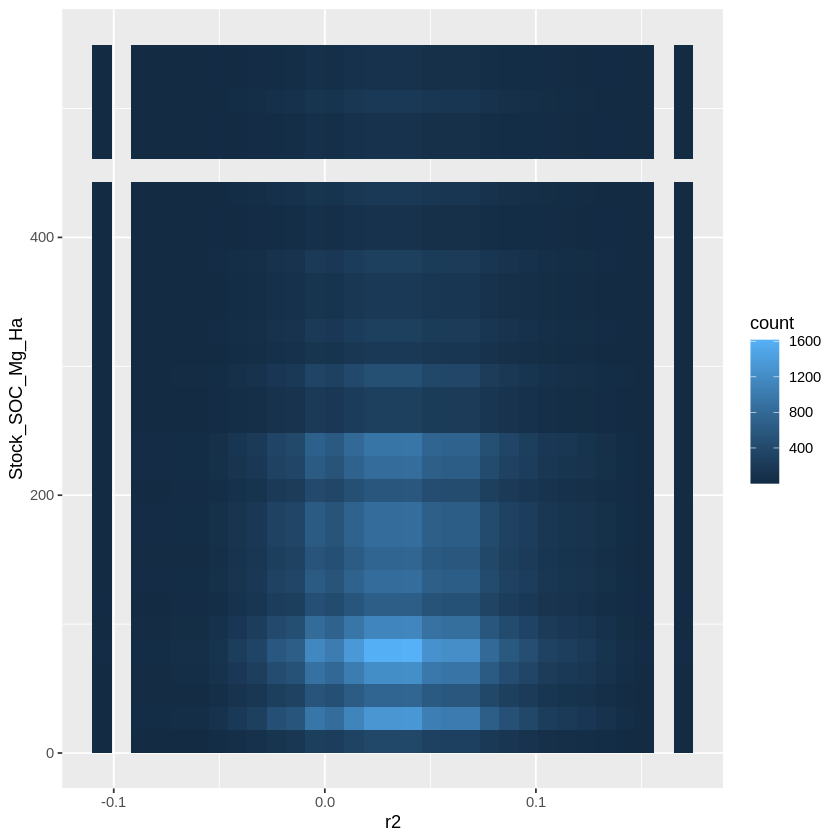

In [283]:
sim_dt %>%
  ggplot(aes(y=Stock_SOC_Mg_Ha,x=r2))+
    geom_bin2d()
    # geom_smooth()

In [ ]:
# Load the necessary library
library(repr)

# Adjust width and height of plots
options(repr.plot.width=20, repr.plot.height=8)

In [ ]:
# for(i in 1:10){

sim_dt[,residual := predicted-Stock_SOC_Mg_Ha]

sim_dt[,residual_per := residual/Stock_SOC_Mg_Ha]

samp_dt <- sim_dt[residual_per>-.05 &residual_per <.05]
plot <- sample(samp_dt$PLOT,1)
# print(plot)
(samp_dt[PLOT==plot] %>% melt(id.vars = c('PLOT','Stock_SOC_Mg_Ha','dummy_geom','water','trees','grass','flooded_vegetation','crops','shrub_and_scrub','built','bare','snow_and_ice','max','elevation','landform','SRTM_mTPI','aet','def','pdsi','pet','pr','ro','soil','srad','swe','tmmn','tmmx','vap','vpd','vs','predicted','residual','residual_per')) %>%
  ggplot(aes(x=variable,y=value))+
  geom_boxplot() )%>% plot
# }

In [ ]:
dummy_geom <- grid_dt[grid_int_dt %>% lapply(function(x){sample(x,1)}) %>% unlist,] %>% st_as_sf() %>% st_transform(4135) %>% st_buffer(2500) %>% st_transform(4326)

In [ ]:
fia_dt$dummy_geom <- dummy_geom$geom

In [ ]:
example_poly <- (fia_dt %>%data.table)[,c('C_TOTAL_PCT','dummy_geom')]

In [ ]:
rf_dt <- data.table(example_poly,exact_extract(raster_list[[6]],example_poly %>% st_as_sf,'mean') %>% data.table)

In [ ]:
# rf_dt

In [ ]:
names(rf_dt)[-c(1,2)] <- c("aet", "def", "pdsi", "pet", "pr", "ro", "soil", "srad", "swe", "tmmn", "tmmx", "vap", "vpd", "vs")


In [ ]:
rf_form <- as.formula(paste0('Stock_SOC_Mg_Ha~',paste((rf_dt %>% names)[-c(1,2)],collapse = '+')))
rf_form

In [ ]:
rf_terra <- randomForest(rf_form,rf_dt[complete.cases(rf_dt[,-2]),],verbose=T)
rf_terra %>% varImpPlot
rf_terra

In [ ]:
data.frame(field = rf_terra$y,predicted = rf_terra$predicted) %>%
  ggplot(aes(x=predicted,y=field))+
  geom_point()